# Freckle Data Engineer Challenge
*22 Oct 2017  
Farooq Qaiser* 

## Admin  

initialize PySpark

In [2]:
import findspark

findspark.init()

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Freckle_challenge") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

Load some of the basic libraries (we'll load others as we need them). 

In [5]:
from pyspark.sql import functions as func

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Set some display options. 

In [6]:
# show plots inline
%matplotlib inline

Set some parameters.  

In [12]:
seed = 1

input_path = "/home/fqaiser94/Data Engineer Challenge/location-data-sample/*.gz"

Read in data as dataframe

In [144]:
df = spark.read.json(input_path)

## RDD vs Dataframe

**RE: The expectation for this exercise is that you use Spark 2.x with Scala, Python, or Java. You can use the RDD or Dataframe APIs as you see fit, but please be ready to explain your choices.**  


I chose to use the Dataframe API over RDD API because:  
1. Dataframe API is able to take advantage of Spark’s Catalyst optimizer by exposing expressions and data fields to a query planner.
2. Dataframe API has speed advantage in most cases (see [here](http://www.adsquare.com/comparing-performance-of-spark-dataframes-api-to-spark-rdd/)). 
3. I find Dataframes an easier construction to work with  

There is obviously also the new Dataset API, which I know little about but apparently it combines the best of both worlds ...

## EDA

Always helpful to do some EDA to understand our data before diving in.  
Lets take a look at the dataframes schema.  

In [17]:
df.printSchema()

root
 |-- action: string (nullable = true)
 |-- api_key: string (nullable = true)
 |-- app_id: string (nullable = true)
 |-- beacon_major: long (nullable = true)
 |-- beacon_minor: long (nullable = true)
 |-- beacon_uuid: string (nullable = true)
 |-- city: string (nullable = true)
 |-- code: string (nullable = true)
 |-- community: string (nullable = true)
 |-- community_code: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- county: string (nullable = true)
 |-- county_code: string (nullable = true)
 |-- event_time: long (nullable = true)
 |-- geohash: string (nullable = true)
 |-- horizontal_accuracy: double (nullable = true)
 |-- idfa: string (nullable = true)
 |-- idfa_hash_alg: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lng: double (nullable = true)
 |-- place: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- state: string (nullable = true)
 |-- state_code: string (nullable = true)
 |-- user_ip: string (nullable =

Humm that's a lot of columns, let's take a peek at our data. 

In [20]:
# show all columns
pd.set_option('display.max_columns', None)

In [21]:
df.limit(5).toPandas()

,action,api_key,app_id,beacon_major,beacon_minor,beacon_uuid,city,code,community,community_code,country_code,county,county_code,event_time,geohash,horizontal_accuracy,idfa,idfa_hash_alg,lat,lng,place,platform,state,state_code,user_ip
0,listrequest,9c4523f4cde116f32bf370656b35129cd9ced93c6ce6c1246,smartphones.collegescoreboard.football,0,0,,Littleton,80123,,,US,Jefferson,059,1491066280,9xj32w4r1z1m,0.0,c50ab245-d660-435e-a226-8d311d2aebbf,,39.628926,-105.092048,Littleton,android,Colorado,CO,184.96.241.157
1,virtual_beacon_list_request,9de1430e73cc96f15272a8a081d127746d3d4ef3d123b6adb,com.airkast.kbxxfm,0,0,,Houston,77067,,,US,Harris,201,1491066280,9vk47vts9tx0,9.0,8c14186b-070d-4933-a28f-a64e97afbb96,,29.957772,-95.452578,Houston,android,Texas,TX,45.18.76.214
2,listrequest,9c4523f4cde116f32bf370656b35129cd9ced93c6ce6c1246,smartphones.collegescoreboard.football,0,0,,Groton,01450,,,US,Middlesex,017,1491066280,drt4k62nrypf,0.0,1ed5c7d3-6b7b-4cbe-a726-7429eb1828c0,,42.596473,-71.531639,Groton,android,Massachusetts,MA,174.192.25.246
3,listrequest,e9d18b6c1b97cd776b1cd0c034a46738493151dc8e512acf0,com.checkout51.rc,0,0,,Media,19063,,,US,Delaware,045,1491066280,dr475f915hgy,0.0,9350ce13-d0a3-422b-a047-0f534d69c217,,39.916275,-75.419635,Media,ios,Pennsylvania,PA,107.77.204.113
4,listrequest,9c4523f4cde116f32bf370656b35129cd9ced93c6ce6c1246,smartphones.collegescoreboard.football,0,0,,Paw Paw,49079,,,US,Van Buren,159,1491066280,dp6zvrr3u6wk,0.0,a6e440f4-695b-42b2-a149-b6da243d7ea5,,42.183695,-85.891952,Paw Paw,android,Michigan,MI,50.107.82.231


Looking at this output, each row/record shows where a user/IDFA was located and at what time. Looks like the information is being generated by apps on a user's phone.  

How many records do we have? 

In [38]:
(df
 .count()
)

8754673

How many countries does this data cover? 

In [22]:
(df
 .select('country_code')
 .distinct()
 .show()
)

+------------+
|country_code|
+------------+
|          LT|
|          DZ|
|          FI|
|          PM|
|          RO|
|          NL|
|          PL|
|          RE|
|          MK|
|          MX|
|          GL|
|          SM|
|          AT|
|          RU|
|          HR|
|          LI|
|          CZ|
|          VA|
|          PT|
|          BD|
+------------+
only showing top 20 rows



In [23]:
(df
 .select('country_code')
 .distinct()
 .count()
)

69

humm that's a lot of countries ... i imagine some are more important than others ...

In [24]:
(df
#  .select('country_code')
#  .distinct()
 .groupby('country_code')
 .agg(func.count('*').alias('records'))
 .orderBy('records', ascending=False)
 .show()
)

+------------+-------+
|country_code|records|
+------------+-------+
|          US|6715156|
|          CA|1921178|
|          JP|  21594|
|          GU|  13946|
|          MX|  12011|
|          GB|   8618|
|          BR|   5658|
|          TR|   5634|
|          DE|   4259|
|          AU|   4217|
|          PK|   3687|
|          NL|   3093|
|          PH|   2904|
|          PR|   2794|
|          BE|   2619|
|          CO|   2421|
|          RU|   2378|
|          ES|   2106|
|          FR|   1768|
|          TH|   1763|
+------------+-------+
only showing top 20 rows



Not surprising, dataset is focused on USA and Canada.     
I like visualizing stuff so let's do a map of user activity.  

In [ ]:
#map

What time period does this data cover? Guessing a lot since its 50GB uncompressed ...

In [145]:
# fix format of event_time column
df = (df
      .withColumn("event_time", func.from_unixtime("event_time"))
     )

In [33]:
(df
 .agg(func.min('event_time').alias('min_time'),
      func.max('event_time').alias('max_time'),
     )
 .toPandas()
)

,min_time,max_time
0,2017-03-31 19:57:38,2017-04-01 20:01:36


oh wow, this dataset has only one day's worth of activity ... and yet its 50GB on disk uncompressed ... nice.      

Alright, let's see what the action column is all about next.   

In [34]:
(df
 .groupby('action')
 .agg(func.count('*').alias('records'))
 .orderBy('records', ascending=False)
 .toPandas()
)

,action,records
0,listrequest,2505370
1,virtual_beacon_list_request,2325582
2,config,1833233
3,enter,1140386
4,exit,773177
5,beacon_list_request,168145
6,visit,7356
7,near,1409
8,,15


I can guess what *enter*, *exit*, *visit*, and *near* refer to ... the rest I don't know ... virtual_beacon_list_request, must ask more about that in interview ... anyway this information seems irrelevant to the questions I've been asked to answer so no biggie.    

Not that this is relevant either but I'm curious to know what some of the biggest apps are that are contributing to this activity.    

In [36]:
(df
 .groupby('app_id')
 .agg(func.count('*').alias('records'))
 .orderBy('records', ascending=False)
 .show(truncate=False)
)

+----------------------------------------+-------+
|app_id                                  |records|
+----------------------------------------+-------+
|smartphones.collegescoreboard.football  |2209154|
|ca.indigo                               |915553 |
|ca.indigo.mobile                        |650734 |
|com.c51                                 |451973 |
|com.airkast.foxfm                       |360640 |
|com.airkast.mark_levin                  |307751 |
|com.airkast.tjms                        |306903 |
|smartphones.collegescoreboard.basketball|199874 |
|com.airkast.wfunfm                      |150798 |
|com.poynt.android                       |123729 |
|com.theweathernetwork.weathereyeiphone  |103781 |
|com.airkast.rsmsfm                      |82547  |
|com.lifelikeapps.classifieds            |78858  |
|com.jacapps.wbns                        |73427  |
|com.airkast.kmjqfm                      |64750  |
|com.mcdonalds.superapp                  |63037  |
|com.multiplied.poynt          

The usual candidates ... radio stations, sports apps and weather apps ... the kinds of apps that most users would have and open on their on phone ... I wonder if the data is being generated only when a user is using a given app or if the data is being generated even when the app is closed or working in the background.

Last but not least, let's just check how much missing data there is in the dataset.   

How much missing data? 

In [146]:
# https://stackoverflow.com/a/33308193

def blank_as_null(x):
    
    return (func.when(func.col(x) != "", func.col(x))
            .otherwise(None))

In [147]:
# identify string fields in df
fields = df.schema.fields

str_fields = []

for i in range(0,len(fields)):
    
    if str(fields[i].dataType) in ['StringType']:
        str_fields.append(fields[i].name)
    
# columns to convert
to_convert = set(str_fields)

to_convert

{'action',
 'api_key',
 'app_id',
 'beacon_uuid',
 'city',
 'code',
 'community',
 'community_code',
 'country_code',
 'county',
 'county_code',
 'event_time',
 'geohash',
 'idfa',
 'idfa_hash_alg',
 'place',
 'platform',
 'state',
 'state_code',
 'user_ip'}

In [152]:
# convert blanks in string columns to None 
exprs = [
    blank_as_null(x).alias(x) if x in to_convert else x for x in df.columns]

df = (df.select(*exprs))

In [153]:
import missingno as msno

In [154]:
# sample 1% of rows randomly
temp = (df
        .sample(False, 0.01, seed)
        .toPandas()
       )

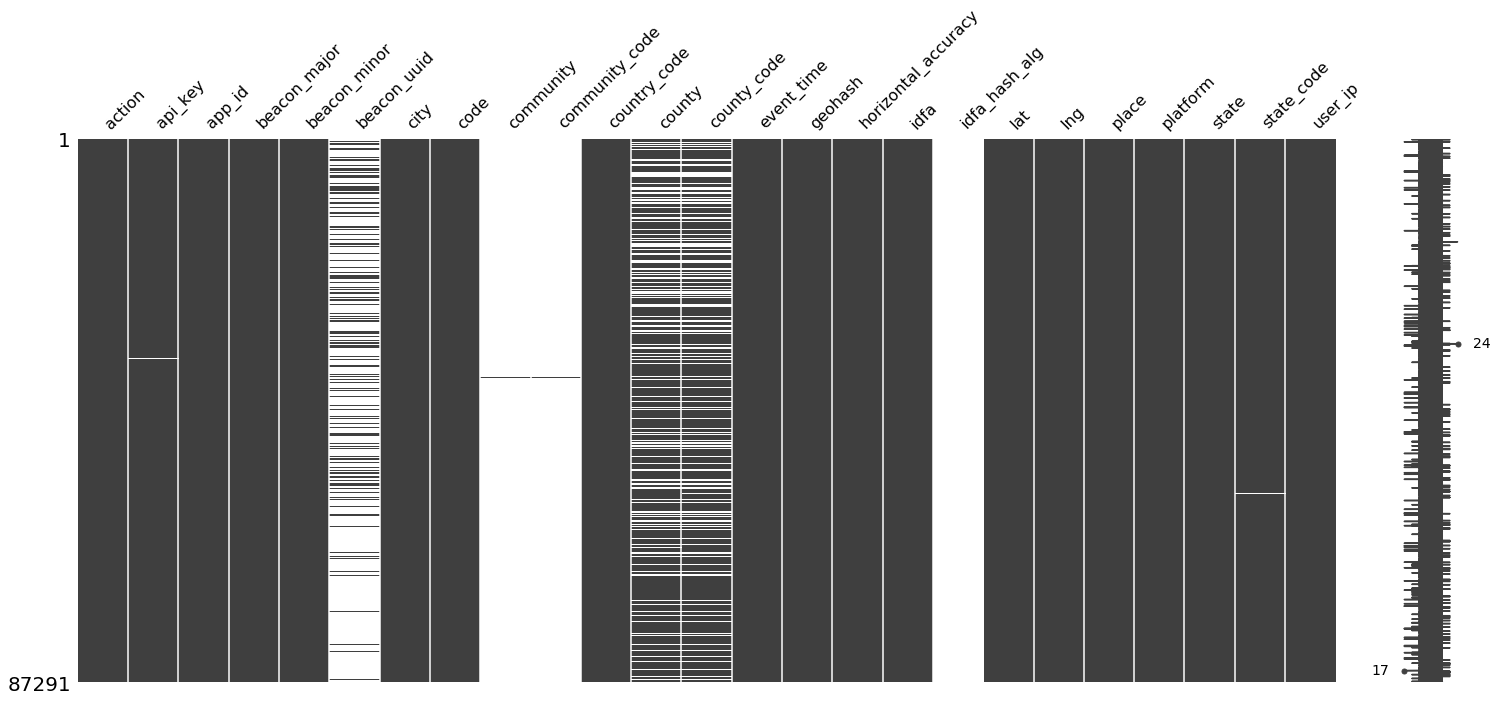

In [155]:
# visualize
msno.matrix(temp, freq=False)
plt.show()

The missing data situation isn't too bad, seems to affect a handful of columns, none of which are super relevant to the challenge questions.     

Cool, think I have a sufficient understanding of the data to actually begin answering the questions from the challenge.  

## IDFA statistics

**RE: What is the max, min, avg, std dev for the location-events per IDFA?  **

Just to be clear, I interpreted question this as:   

1. What is the maximum **number of** location-events per IDFA? 
2. What is the minimum **number of** location-events per IDFA? 
3. What is the average **number of** location-events per IDFA? 
4. What is the standard deviation **number of** location-events per IDFA? 

I assume that each entry/row/record in this dataset is a "location-event."  

In [157]:
# calculate count of locations per idfa 
count = (df
         .groupby('idfa')
         .agg(func.count('*').alias('count'))
        )

count.show(5, truncate=False)

+------------------------------------+-----+
|idfa                                |count|
+------------------------------------+-----+
|b5b237fe-4ab2-4f00-a7c8-c6fa40f30c37|28   |
|0894896b-1b58-4b88-bd1a-a03999ff410c|58   |
|0446d012-6d80-4b26-b311-997fcbbfb02c|36   |
|564fa141-580a-4453-bf9b-29e57d29dc95|72   |
|4bf5568f-4369-4219-bc32-4e257ca389ed|31   |
+------------------------------------+-----+
only showing top 5 rows



In [158]:
# calculate min, avg, max, std dev and n for counts
stats = (count
         .agg(func.min('count').alias('min'),
              func.avg('count').alias('avg'),
              func.max('count').alias('max'),
              func.stddev('count').alias('stddev'), 
              func.sum('count').alias('n'))
            )

stats.show(5, truncate=False)

+---+----------------+-----+------------------+-------+
|min|avg             |max  |stddev            |n      |
+---+----------------+-----+------------------+-------+
|1  |36.7517578953113|15979|118.61139276213814|8754673|
+---+----------------+-----+------------------+-------+



In [159]:
temp = (stats
        .toPandas()
        .transpose()
        .reset_index()
        .rename(columns={'index': 'statistic', 0: 'value'})
       )

temp.value = temp.value.round()

temp

,statistic,value
0,min,1.0
1,avg,37.0
2,max,15979.0
3,stddev,119.0
4,n,8754673.0


This is a useful summary of the distribution of the data but I find histograms to be a little easier to digest. 

In [160]:
histogram = (count
             .select('count')
             .filter("count <= 500")
             # bad solution switching to rdd
             # sadly histogram is not available for DFs
             .rdd
             .flatMap(lambda x: x)
             .histogram(1000)
            )

In [161]:
temp = (pd.DataFrame(list(histogram))
        .transpose()
        .rename(columns={0: 'bin', 1: 'count'})
       )

temp['bin'] = round(temp['bin'], 2)

temp = temp.set_index('bin')

# temp.head()

/home/fqaiser94/.local/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


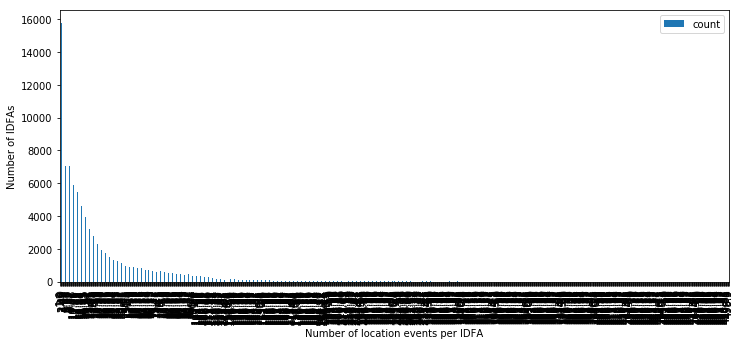

In [163]:
n = 50

ax = temp.plot(kind='bar', y='count', figsize=(12, 5))

plt.ylabel('Number of IDFAs')
plt.xlabel('Number of location events per IDFA')

ax.figure.show()

Humm, since this dataset really only covers a day, it makes sense that ~99% of IDFA have less than 300 locations-events associated with them. 

##  Geohashing

**RE: Produce geohashes for all coordinates in a new RDD or DataFrame.**  

Great intro to [geohashing](http://www.bigfastblog.com/geohash-intro)  
[Wiki](https://en.wikipedia.org/wiki/Geohash) on geohashing

In [164]:
# if you get an error running this cmd, try installing via the following cmd
# sudo pip install python-geohash

import Geohash

Let's see what methods we have in Geohash. 

In [166]:
dir(Geohash) 

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'decode',
 'decode_exactly',
 'encode']

*encode* sounds like what we're looking for, let's see what help says. 

In [167]:
help(Geohash.encode)

Help on function encode in module geohash:

encode(latitude, longitude, precision=12)



In [190]:
def geohash_coords(lat,lng,precision):
    
    """
    Function to return hash code for a coordinate of a given precision
    """
    
    hashcode = Geohash.encode(lat,lng)[:precision]
    
    return hashcode

In [191]:
strg = geohash_coords(lat=49,lng=-84,precision=15)

Lat and long are provided with each record in our dataset. The only question is what level precision do we want? Since we're trying to find clusters of people, the precision should be high. I would consider people in the same building to be a cluster. I would not consider people in the same city to be a cluster. Let's see what level of precision would correspond to a building.  

In [192]:
import pyproj
from shapely.geometry import shape
from shapely.ops import transform
from functools import partial

In [193]:
def calc_area_metres(y,x,yerror,xerror):
    
    """
    https://gist.github.com/robinkraft/c6de2f988c9d3f01af3c
    get the area in square meters of a polygon using shapely and pyproj
    """
    
    # bottom left corner of rectangle
    y1 = y - yerror
    x1 = x - xerror
    
    # top left corner of rectangle
    y2 = y + yerror
    x2 = x - xerror
    
    # top right corner of rectangle
    y3 = y + yerror
    x3 = x + xerror
    
    # bottom right corner of rectangle
    y4 = y - yerror
    x4 = x + xerror
    
    geom = {'type': 'Polygon',
            'coordinates': [[[y1, x1], [y2, x2],
                             [y3, x3], [y4, x4], 
                             [y1, x1]]]}

    s = shape(geom)
    
    proj = partial(pyproj.transform, pyproj.Proj(init='epsg:4326'),
                   pyproj.Proj(init='epsg:3857'))

    s_new = transform(proj, s)

    projected_area = transform(proj, s).area

    return projected_area

In [194]:
# https://gis.stackexchange.com/questions/231719/calculating-optimal-geohash-precision-from-bounding-box
# https://gis.stackexchange.com/questions/115280/what-is-the-precision-of-a-geohash

strg = geohash_coords(lat=49,lng=-84,precision=15)

for prec in range(1,11):
    
    y,x,yerror,xerror = Geohash.decode_exactly(strg[:prec])
    xsize = 2*xerror
    ysize = 2*yerror
    area = xsize*ysize
    area_meters = calc_area_metres(y=y,x=x,yerror=yerror,xerror=xerror)
    
    print("Precision {}".format(prec))
    print("\tDecoded coordinates are ({},{})".format(y,x))
    print("\tSize is approximately {} long by {} lat".format(xsize,ysize))
    print("\tArea is {} approximately square degrees".format(area))
    print("\tArea is {} approximately square meters".format(round(area_meters,0)))

Precision 1
	Decoded coordinates are (67.5,-67.5)
	Size is approximately 45.0 long by 45.0 lat
	Area is 2025.0 approximately square degrees
	Area is nan approximately square meters
Precision 2
	Decoded coordinates are (47.8125,-84.375)
	Size is approximately 11.25 long by 5.625 lat
	Area is 63.28125 approximately square degrees
	Area is nan approximately square meters
Precision 3
	Decoded coordinates are (48.515625,-83.671875)
	Size is approximately 1.40625 long by 1.40625 lat
	Area is 1.9775390625 approximately square degrees
	Area is 223250076108.0 approximately square meters
Precision 4
	Decoded coordinates are (48.955078125,-83.84765625)
	Size is approximately 0.3515625 long by 0.17578125 lat
	Area is 0.061798095703125 approximately square degrees
	Area is 7147471764.0 approximately square meters
Precision 5
	Decoded coordinates are (49.02099609375,-84.00146484375)
	Size is approximately 0.0439453125 long by 0.0439453125 lat
	Area is 0.0019311904907226562 approximately square degre

In [188]:
geohash_coords_udf = func.udf(geohash_coords, StringType())

In [189]:
df_geohash = (df
              .withColumn("geohash_2", 
                          geohash_coords_udf("lat", "lng", func.lit(9)))
             )

df_geohash.limit(5).toPandas()

,action,api_key,app_id,beacon_major,beacon_minor,beacon_uuid,city,code,community,community_code,country_code,county,county_code,event_time,geohash,horizontal_accuracy,idfa,idfa_hash_alg,lat,lng,place,platform,state,state_code,user_ip,geohash_2
0,listrequest,9c4523f4cde116f32bf370656b35129cd9ced93c6ce6c1246,smartphones.collegescoreboard.football,0,0,None,Littleton,80123,None,None,US,Jefferson,059,2017-04-01 13:04:40,9xj32w4r1z1m,0.0,c50ab245-d660-435e-a226-8d311d2aebbf,None,39.628926,-105.092048,Littleton,android,Colorado,CO,184.96.241.157,9xj32w4r1
1,virtual_beacon_list_request,9de1430e73cc96f15272a8a081d127746d3d4ef3d123b6adb,com.airkast.kbxxfm,0,0,None,Houston,77067,None,None,US,Harris,201,2017-04-01 13:04:40,9vk47vts9tx0,9.0,8c14186b-070d-4933-a28f-a64e97afbb96,None,29.957772,-95.452578,Houston,android,Texas,TX,45.18.76.214,9vk47vts9
2,listrequest,9c4523f4cde116f32bf370656b35129cd9ced93c6ce6c1246,smartphones.collegescoreboard.football,0,0,None,Groton,01450,None,None,US,Middlesex,017,2017-04-01 13:04:40,drt4k62nrypf,0.0,1ed5c7d3-6b7b-4cbe-a726-7429eb1828c0,None,42.596473,-71.531639,Groton,android,Massachusetts,MA,174.192.25.246,drt4k62nr
3,listrequest,e9d18b6c1b97cd776b1cd0c034a46738493151dc8e512acf0,com.checkout51.rc,0,0,None,Media,19063,None,None,US,Delaware,045,2017-04-01 13:04:40,dr475f915hgy,0.0,9350ce13-d0a3-422b-a047-0f534d69c217,None,39.916275,-75.419635,Media,ios,Pennsylvania,PA,107.77.204.113,dr475f915
4,listrequest,9c4523f4cde116f32bf370656b35129cd9ced93c6ce6c1246,smartphones.collegescoreboard.football,0,0,None,Paw Paw,49079,None,None,US,Van Buren,159,2017-04-01 13:04:40,dp6zvrr3u6wk,0.0,a6e440f4-695b-42b2-a149-b6da243d7ea5,None,42.183695,-85.891952,Paw Paw,android,Michigan,MI,50.107.82.231,dp6zvrr3u


Cheating a little here but you can see our geohashes (geohash_2) are very similar to the ones provided with the dataset (geohash column), just a slightly lower precision.  

## Clustering

** RE: Using the geohashes, determine if there clusters of people at any point in this dataset. If so, how many people and how close are they?**  

Aight, so my definition of a cluster is when there a large (>100) number of people in building-sized area during any hour. Let's see if we can find any cluster that meets this definition using our geohashes.  

In [195]:
cluster = (df_geohash
           # we can exploit the fact that this dataset only contains 1 day
           # otherwise this code would be erroneous
           .withColumn('hour', func.hour('event_time'))
           .groupby('geohash_2', 'hour')
           .agg(func.countDistinct('idfa').alias('users'))
           .filter("users >= 10")
           .orderBy('users', ascending=False)
          )

cluster.limit(20).toPandas()

,geohash_2,hour,users
0,s00000000,13,355
1,s00000000,12,336
2,s00000000,11,333
3,s00000000,16,332
4,s00000000,14,320
5,s00000000,18,319
6,s00000000,17,305
7,s00000000,20,292
8,s00000000,21,290
9,s00000000,19,289


Getting a lot of users from the village of Barrigada in the United States territory of Guam. That doesn't make any sense ... let's try excluding s00000000.  

In [ ]:
ignore = 's00000000'

cluster = (df_geohash
           .filter(func.col('geohash_2')!= ignore)
           # we can exploit the fact that this dataset only contains 1 day
           # otherwise this code would be erroneous
           .withColumn('hour', func.hour('event_time'))
           .groupby('geohash_2', 'hour')
           .agg(func.countDistinct('idfa').alias('users'))
           .filter("users >= 10")
           .orderBy('users', ascending=False)
          )

cluster.limit(20).toPandas()

That makes more sense. Sadly, the "clusters" appear to be quite small, with less than 22 users in most cases.   

To answer the question then, no, I do not see any clusters of people at any point in this dataset.  